## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## データセットの準備

In [ ]:
# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d ashaheedq/video-games-sales-2019 -p /content/drive/MyDrive/kaggle

# 解凍
!unzip /content/drive/MyDrive/kaggle/video-games-sales-2019.zip -d /content/drive/MyDrive/kaggle

!rm /content/drive/MyDrive/kaggle/video-games-sales-2019.zip

     |████████████████████████████████| 58 kB 4.6 MB/s 
     |████████████████████████████████| 247 kB 23.9 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=1e3afa2e6304b638a8c02e8824ee3ad47a0155a48faba12de64ccf5cf1abb3e7
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/3.98M [00:00<?, ?B/s]
100% 3.98M/3.98M [00:00<00:00, 136MB/s]
Archive:  /content/drive/MyDrive/kaggle/video-games-sales-2019.zip
replace /content/drive/MyDrive/kaggle/vgsales-12-4-2019-short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


## データの読込

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/kaggle/vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


In [ ]:
!pip install japanize-matplotlib

  Using cached japanize_matplotlib-1.1.3-py3-none-any.whl
     |████████████████████████████████| 11.2 MB 12.3 MB/s 
     |████████████████████████████████| 1.1 MB 31.4 MB/s 
     |████████████████████████████████| 15.7 MB 35.4 MB/s 
     |████████████████████████████████| 3.1 MB 40.1 MB/s 
     |████████████████████████████████| 97 kB 6.6 MB/s 
     |████████████████████████████████| 890 kB 37.5 MB/s 
     |████████████████████████████████| 40 kB 5.2 MB/s 


## cuda-tesne のインストール

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda101.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda101.tar.bz2
!cp -r site-packages/* /usr/local/lib/python3.7/dist-packages/

!conda install --offline tsnecuda-2.1.0-cuda101.tar.bz2

✨🍰✨ Everything looks OK!
--2021-12-22 12:46:21--  https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda101.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.93.24, 104.17.92.24, 2606:4700::6811:5d18, ...
Connecting to anaconda.org (anaconda.org)|104.17.93.24|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5d019c23c7424a015486440c/5d790a987870581667a307cf?response-content-disposition=attachment%3B%20filename%3D%22tsnecuda-2.1.0-cuda101.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27tsnecuda-2.1.0-cuda101.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20211222T124622Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEDIaCXVzLWVhc3QtMSJIMEYCIQDDjUOwOzuaSVaM59miAf9Uw0U4NyXCTSaH3UzO%2BgEBoQIhAKBmUKJBw%2FMXObXaKcvaT3XuT4ld1tzkT9NhHCD%2BcTqbKvoDCCsQABoMNDU1ODY0MDk4Mzc4IgxOg6RHEoOXe5Ju1Nsq1wMsfZVhSbeSXdPlHtUd

In [ ]:
import os
import time
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from natsort import natsorted 
import collections

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples
from matplotlib import cm
from tsnecuda import TSNE

import warnings
warnings.simplefilter('ignore')

In [ ]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
### パイプライン

# 数値データカラム名を取得
number_columns = df.select_dtypes(include="number").columns
number_columns = list(number_columns)

# カテゴリデータカラム名を取得
category_columns = df.select_dtypes(include="object").columns
category_columns = list(category_columns)

# 数値データ用の変換
numeric_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
)

# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping = []

for column in df.select_dtypes(include="object"):
    ordinal_one_cols_mapping = []
    for category in natsorted(df[column].unique()):
        ordinal_one_cols_mapping.append(category)

    ordinal_all_cols_mapping.append(ordinal_one_cols_mapping)


# カテゴリー数が少ないカテゴリーデータ用の変換
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(
                handle_unknown = 'use_encoded_value', # 未知数をunknown valueに置き換える設定
                unknown_value = -1,
                categories = ordinal_all_cols_mapping
            )
        )
    ]
)

# ColumnTransformerの作成
columns_transformers = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, number_columns),
        ('category', categorical_transformer, category_columns),
    ]
)

# カラム変換用のパイプラインの作成
transformer = Pipeline(
    [
        ("columns_transformers", columns_transformers),
    ]
)

In [ ]:
df_tf = transformer.fit_transform(df)

all_columns = df.columns.tolist()
all_columns.remove("VGChartz_Score")

df_tf = pd.DataFrame(
    df_tf,
    columns = all_columns
)

## エルボー法

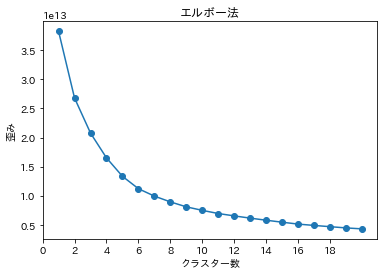

In [ ]:
distortions = []
num = 20

for i  in range(1,num+1):
    model = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=SEED
    )
    
    model.fit(df_tf)

    distortions.append(model.inertia_)

plt.title("エルボー法")
plt.plot(
    range(1,num+1),
    distortions,
    marker='o'
    )

plt.xlabel('クラスター数')
plt.xticks( np.arange(0, num, 2))
plt.ylabel('歪み')
plt.show()

## シルエット法

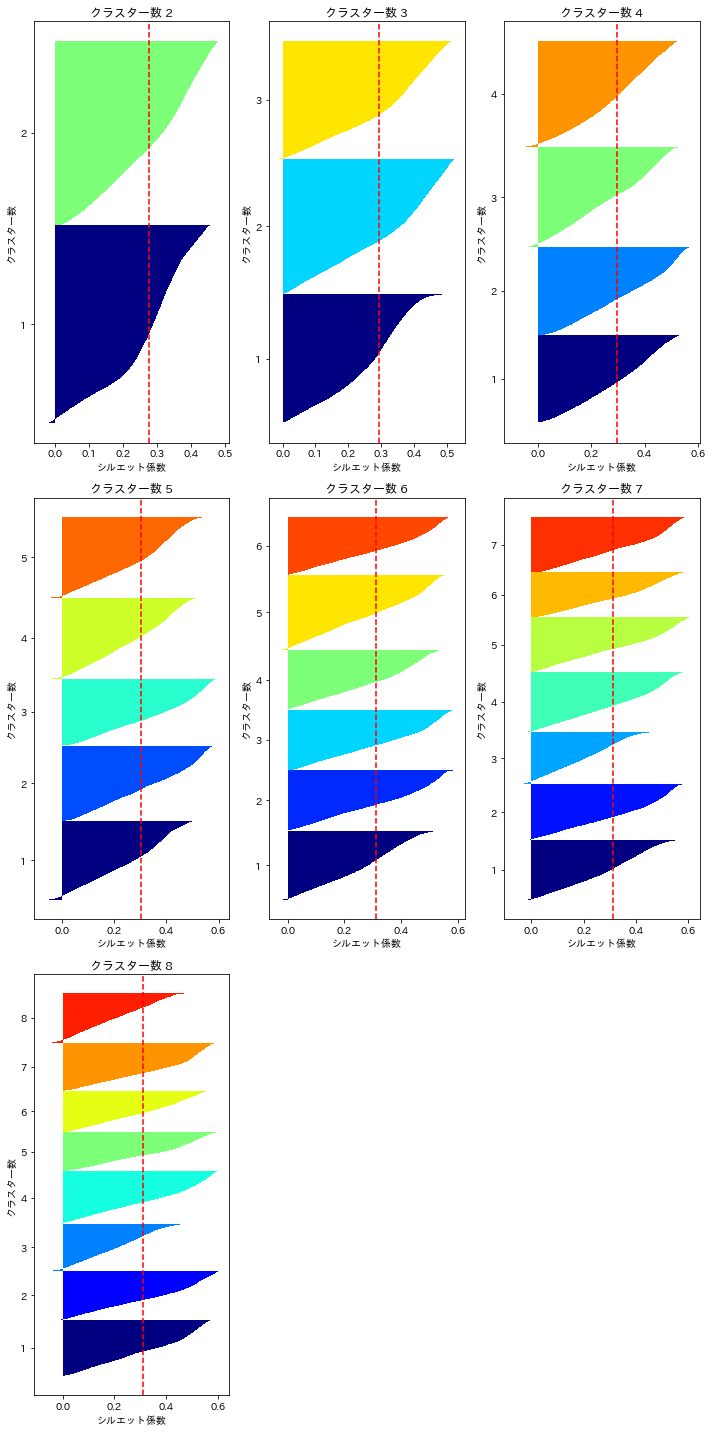

In [ ]:
num = 8
fig = plt.figure(figsize=(10,20))

for k in range(2, num+1):
    
    kmeans_num = KMeans(
        n_clusters=k, 
        random_state=SEED
        ).fit_predict(df_tf)

    cluster_labels = np.unique(kmeans_num)       # y_kmの要素の中で重複を無くす
    n_clusters=cluster_labels.shape[0]           # 配列の長さを返す。つまりここでは n_clustersで指定した数となる

    # シルエット係数を計算
    silhouette_vals = silhouette_samples(
                                            df_tf,
                                            kmeans_num,
                                            metric='euclidean'
                                        )  # サンプルデータ, クラスター番号、ユークリッド距離でシルエット係数計算

    y_ax_lower, y_ax_upper= 0,0
    yticks = []

    # グラフ
    plt.subplot((num//3+1), 3, k-1)
    
    for i,c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[kmeans_num==c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)              # サンプルの個数をクラスターごとに足し上げてy軸の最大値を決定
        color = cm.jet(float(i)/n_clusters)               # 色の値を作る
        plt.barh(range(y_ax_lower,y_ax_upper),            # 水平の棒グラフのを描画（底辺の範囲を指定）
                         c_silhouette_vals,               # 棒の幅（1サンプルを表す）
                         height=1.0,                      # 棒の高さ
                         edgecolor='none',                # 棒の端の色
                         color=color)                     # 棒の色
        yticks.append((y_ax_lower+y_ax_upper)/2)          # クラスタラベルの表示位置を追加
        y_ax_lower += len(c_silhouette_vals)              # 底辺の値に棒の幅を追加

    silhouette_avg = np.mean(silhouette_vals)                 # シルエット係数の平均値
    plt.axvline(silhouette_avg,color="red",linestyle="--")    # 係数の平均値に破線を引く
    plt.title(f"クラスター数 {k}")
    plt.yticks(yticks,cluster_labels + 1)                     # クラスタレベルを表示
    plt.ylabel('クラスター数')
    plt.xlabel('シルエット係数')

plt.tight_layout()

## クラスタリング

### k-means

In [ ]:
# パイプラインの作成
k = 5

pipe = Pipeline(
    [
        ("columns_transformers", columns_transformers),
        ('model', KMeans(
                    n_clusters=k,
                    random_state=SEED,
                    init='k-means++',
                    n_init=10,
                    max_iter=300,
                )
         )
     ]
)

In [ ]:
pipe.fit(df)

labels = pipe.predict(df)

print(collections.Counter(labels))

Counter({3: 11822, 4: 11748, 0: 11522, 1: 10934, 2: 9766})


## TSNE による主成分分析と合わせてクラスタリング結果を可視化

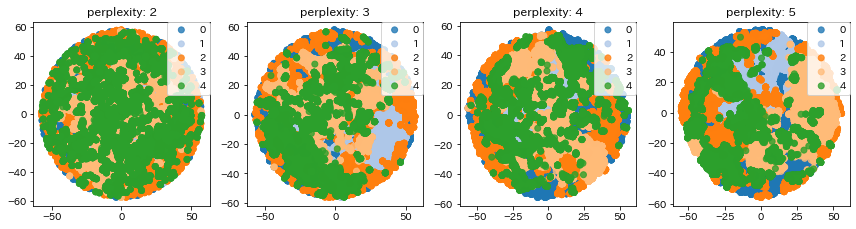

In [ ]:
fig = plt.figure(figsize=(12,6))

num = 6

for i in range(2, num):
    plt.subplot((num//4+1), 4, i-1)
    plt.title(f"perplexity: {i}")
    
    model_tsne = TSNE(n_components=2, perplexity=i)
    feature = model_tsne.fit_transform(df_tf)

    for label in natsorted(np.unique(labels)):

        colors = [plt.get_cmap("tab20")(x) for x in np.array(labels)[labels==label]]

        plt.scatter(feature[:, 0][labels==label], feature[:, 1][labels==label], alpha=0.8, color=colors, label=label)

    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0)

plt.tight_layout()